**write a function that takes a filename as input and returns the rgb image, positive samples and negative samples**

In [1]:
import h5py as h5

import glob
import os
import pickle
import time
import warnings
from typing import Any, Dict
import decord
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from decord import VideoReader, cpu
from physvec.utils import data_utils
from skimage.transform import resize
from torch.utils.data import Dataset
from torch.utils.data import Dataset
from torchvision import transforms

def get_positive_and_negative_pairs(filename, index):
    
    with h5.File(filename) as h5_file:
        
        index_start = index#np.random.randint(0, num_frames)

        #convert to numpy array
        indices = np.array([index_start])

        rgb_imgs, seg_imgs = data_utils.index_imgs(h5_file, indices, suffix='_cam0', pil=True)
        seg_colors = h5_file['static']['object_segmentation_colors'][:]

        m_names = np.array(h5_file['static']['model_names'])
        occluders = np.array(h5_file['static']['occluders'])
        distractors = np.array(h5_file['static']['distractors'])

        obj_masks = data_utils.get_object_masks(seg_imgs, seg_colors, True)  # O x N x 1 x H x W
        obj_masks = obj_masks.transpose([1, 0, 2, 3, 4])[0, :, 0]  # N x O x 1 x H x W

        rgb = np.array(rgb_imgs[0])
        obj_masks = [x for x in obj_masks if x.sum() != 0]
        fg_mask = obj_masks[1:-1]
        bg_mask = obj_masks[0] + obj_masks[-1]

        n_positive = 10

        height_mask = fg_mask[0].shape[0]
        where_trues = []
        for mask in fg_mask:
            mask_flat = mask.flatten()
            where_true = np.where(mask_flat)[0]
            where_trues.append(where_true)

        def sample_pair_on_mask(where_true):

            np.random.shuffle(where_true)

            index_visible = where_true[0] #[np.random.randint(len(where_true))]

            index_visible_x = (index_visible//height_mask)
            index_visible_y = (index_visible%height_mask)

            return index_visible, index_visible_x, index_visible_y

        all_xy = []

        for x in range(n_positive):
            n_objs = len(where_trues)
            wt = np.random.choice(n_objs)
            if x < n_objs:
                wt = x
            wt = where_trues[wt]
            ind, x1, y1 = sample_pair_on_mask(wt)
            ind, x2, y2 = sample_pair_on_mask(wt)

            all_xy.append([[x1, y1], [x2, y2]])

        bg_mask_flat = bg_mask.flatten()
        where_true_bg = np.where(bg_mask_flat)[0]

        where_trues_with_bg = where_trues + [where_true_bg]

        all_xy_neg = []

        for x in range(n_positive):

            n_objs = len(where_trues)

            valid_inds = list(np.arange(n_objs+1))

            wt = np.random.choice(n_objs)

            if x < n_objs:
                wt = x
            wtrue = where_trues[wt]

            valid_inds.remove(wt)

            ind, x1, y1 = sample_pair_on_mask(wtrue)

            #randomly choose second object incl bkg
            wt = np.random.choice(valid_inds)
            wtrue = where_trues_with_bg[wt]
            ind, x2, y2 = sample_pair_on_mask(wtrue)

            all_xy_neg.append([[x1, y1], [x2, y2]])

    return all_xy, all_xy_neg, seg_colors


from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch

class PhysionSeg(Dataset):
    def __init__(self, features, filenames_):
        # Initialize any prerequisites such as paths to files, transformations, etc.
        # Load your dataset here
        
        self.features = features
        self.filenames = filenames_
        
        self.indices = [30, 45]
        
    def __len__(self):
        # Return the total number of samples in the dataset
#         print(len(self.filenames))
        return len(self.filenames)

    def __getitem__(self, idx):
        # Return the idx-th sample from the dataset
        xx = np.random.choice([0, 1])
        
        feature = self.features[idx][xx]
        
        filename = self.filenames[idx]

        positive_inds, negative_inds, seg_colors = get_positive_and_negative_pairs(filename, self.indices[xx])
        
        positive_inds = np.array(positive_inds)
        
        negative_inds = np.array(negative_inds)
        
        return feature, positive_inds, negative_inds
    
def pos_embedding(positions, hidden_dim, device='cuda'):

    if isinstance(positions, int):
        positions = torch.arange(positions).float().to(device)
    elif isinstance(positions, torch.Tensor):
        positions = positions.clone().detach().float().requires_grad_(True).to(device)
    else:
        assert hasattr(positions, '__len__')
        positions = torch.tensor(positions, dtype=torch.float).to(device)
    freqs = torch.arange(hidden_dim).float().to(device)
    # freqs = torch.pow(10000, 2 * (freqs // 2) / hidden_dim)
    freqs = torch.pow(10000, 2 * (torch.div(freqs, 2, rounding_mode='trunc')) / hidden_dim)    
    out = positions[:,None] / freqs[None,:]
    out[:, 0::2] = torch.sin(out[:, 0::2]) # dim 2i
    out[:, 1::2] = torch.cos(out[:, 1::2]) # dim 2i+1
    return out.unsqueeze(0)

import torch.nn as nn

# Model Definition
class TransformerClassifier(nn.Module):
    def __init__(self, input_feat_size, nhead, num_pos, embed_dim, num_classes=1):
        super(TransformerClassifier, self).__init__()
        
        self.embedding = nn.Linear(input_feat_size, embed_dim)
        self.pos_embedding = pos_embedding(num_pos, embed_dim, device='cuda')
        encoder_layers = nn.TransformerEncoderLayer(embed_dim, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_embedding + x
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, -1, :])
        return x.squeeze(-1)
    
def get_loss_accuracy(input_data, pembed):
    
    feature, pos_inds, neg_inds = input_data

    feature = torch.stack([feature]*n_points_sample, 1).flatten(0, 1).to('cuda')

    batch_size = feature.shape[0]

    pos_embed_pos_inds = pembed[0][pos_inds.flatten()].view(batch_size, -1, feature.shape[-1])

    pos_embed_neg_inds = pembed[0][neg_inds.flatten()].view(batch_size, -1, feature.shape[-1])

    pos_feature = torch.cat([feature, pos_embed_pos_inds], 1)
    neg_feature = torch.cat([feature, pos_embed_neg_inds], 1)
    all_feature = torch.cat([pos_feature, neg_feature])
    class_token = torch.zeros(all_feature.shape[0], 1, all_feature.shape[-1]).to('cuda')
    input_to_transformer = torch.cat([all_feature, class_token], 1)

    gt = torch.cat([torch.ones(pos_feature.shape[0]), torch.zeros(neg_feature.shape[0])]).cuda()

    op = classifier(input_to_transformer)
    
    loss = loss_fn(op, gt)

    predicted = torch.sigmoid(op) > 0.5
    accuracy = (predicted.float() == gt).float().mean()
    
    return loss, accuracy

In [2]:
import torch

img_size = 512
n_points_sample = 10
embed_dim = 384
split_perc = 0.9
input_feat_dim = 3

train_hdf5 = '/ccn2/u/rmvenkat/data/test_with_keypoint_model_3_feats/Kevin_2frame/train_features.hdf5'

h5_file = h5py.File(train_hdf5)

filenames = h5_file['filenames']

drop_inds = []
filenames_drop = []
for ct, x in enumerate(filenames):
    if b'drop' in x:
        drop_inds.append(ct)
        filenames_drop.append(x)
    
features = h5_file['features']

features = features[np.array(drop_inds)]

if input_feat_dim is None: input_feat_dim = features.shape[0]

dataset_size = len(features)
train_size = int(split_perc*dataset_size)

arr = np.arange(dataset_size)

np.random.shuffle(arr)

inds_train = arr[:train_size]

inds_val = arr[train_size:]

features_train = features[inds_train]
filenames_train = list(np.array(filenames_drop)[inds_train])

features_val = features[inds_val]
filenames_val = list(np.array(filenames_drop)[inds_val])


loss_fn = nn.BCEWithLogitsLoss()

dataset_train = PhysionSeg(features_train, filenames_train)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=5, shuffle=True)

dataset_val = PhysionSeg(features_val, filenames_val)

dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=5, shuffle=True)


classifier = TransformerClassifier(input_feat_dim, 4, features.shape[-2] + 5, embed_dim).cuda()
pembed = pos_embedding(img_size, features.shape[-1], 'cuda')

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

RuntimeError: random_device could not be read

In [111]:
num_val_batches = 5
val_after = 100
global_step = 0
num_epochs = 1000
for epoch in range(num_epochs):
    for ct, xx in enumerate(dataloader_train):
        t_loss, t_accuracy = get_loss_accuracy(xx, pembed)

        optimizer.zero_grad()
        t_loss.backward()
        global_step += 1
        optimizer.step()

        if (global_step % val_after) == 0:
            classifier.eval()
            val_accs = 0
            val_losses = 0
            sum_val_nos = 0
            for ct_, xx in enumerate(dataloader_val):
                with torch.no_grad():
                    loss, accuracy = get_loss_accuracy(xx, pembed)
                    sz = len(xx[0])
                    loss = loss*sz
                    accuracy = accuracy*sz
                    sum_val_nos += sz
                    val_accs += accuracy
                    val_losses += loss
                if ct_ > num_val_batches:
                    break
            val_loss = val_losses/sum_val_nos
            val_acc = val_accs/sum_val_nos
            classifier.train()

            print("val loss, acc at iter " + str(global_step).zfill(4) + " is " + str(val_loss), str(val_acc))
            print("train loss, acc at iter " + str(global_step).zfill(4) + " is " + str(t_loss), str(t_accuracy))

    
#     break

val loss, acc at iter 0100 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 0100 is tensor(0.6887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5600, device='cuda:0')
val loss, acc at iter 0200 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 0200 is tensor(0.6909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4900, device='cuda:0')
val loss, acc at iter 0300 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 0300 is tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5000, device='cuda:0')
val loss, acc at iter 0400 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 0400 is tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5300, device='cuda:0')
val loss, acc at

val loss, acc at iter 3700 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 3700 is tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5400, device='cuda:0')
val loss, acc at iter 3800 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 3800 is tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5100, device='cuda:0')
val loss, acc at iter 3900 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 3900 is tensor(0.6984, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4400, device='cuda:0')
val loss, acc at iter 4000 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 4000 is tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4300, device='cuda:0')
val loss, acc at

val loss, acc at iter 7100 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 7100 is tensor(0.6871, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5700, device='cuda:0')
val loss, acc at iter 7200 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 7200 is tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4600, device='cuda:0')
val loss, acc at iter 7300 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 7300 is tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5400, device='cuda:0')
val loss, acc at iter 7400 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 7400 is tensor(0.6907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5400, device='cuda:0')
val loss, acc at

val loss, acc at iter 10500 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 10500 is tensor(0.6888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5700, device='cuda:0')
val loss, acc at iter 10600 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 10600 is tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5200, device='cuda:0')
val loss, acc at iter 10700 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 10700 is tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4600, device='cuda:0')
val loss, acc at iter 10800 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 10800 is tensor(0.6976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4800, device='cuda:0')
val loss

val loss, acc at iter 13900 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 13900 is tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4200, device='cuda:0')
val loss, acc at iter 14000 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 14000 is tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4800, device='cuda:0')
val loss, acc at iter 14100 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 14100 is tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4600, device='cuda:0')
val loss, acc at iter 14200 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 14200 is tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5200, device='cuda:0')
val loss

val loss, acc at iter 17300 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 17300 is tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5800, device='cuda:0')
val loss, acc at iter 17400 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 17400 is tensor(0.6906, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4800, device='cuda:0')
val loss, acc at iter 17500 is tensor(0.6932, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 17500 is tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4800, device='cuda:0')
val loss, acc at iter 17600 is tensor(0.6931, device='cuda:0') tensor(0.5000, device='cuda:0')
train loss, acc at iter 17600 is tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5500, device='cuda:0')
val loss

KeyboardInterrupt: 

In [109]:
t_accuracy, val_loss

(tensor(0.4500, device='cuda:0'), tensor(0.6931, device='cuda:0'))

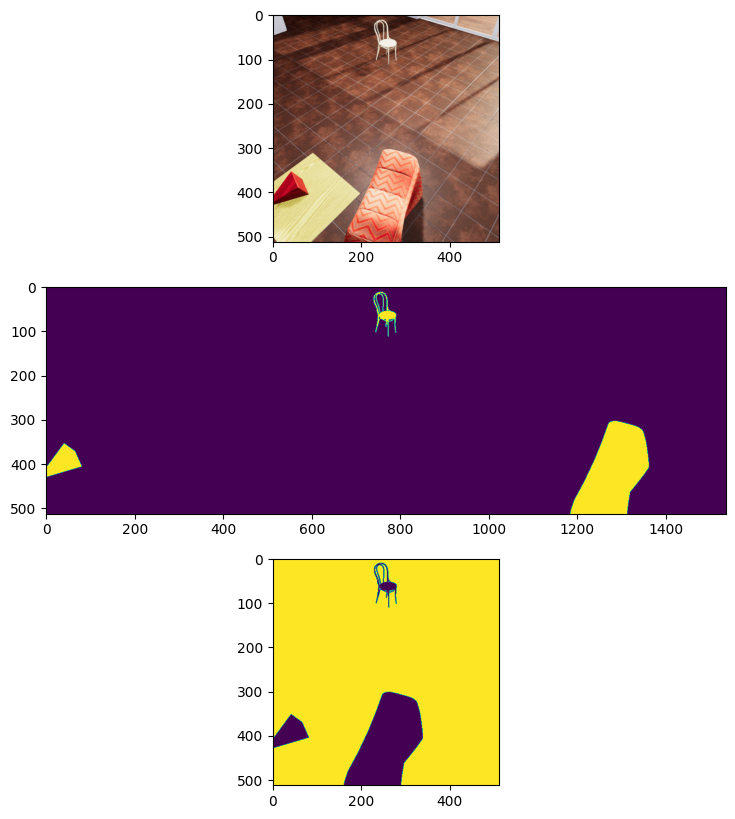

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
rgb = np.array(rgb_imgs[0])
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(311)
ax.imshow(rgb)

obj_masks = [x for x in obj_masks if x.sum() != 0]
fg_mask = obj_masks[1:-1]

obj_masks_viz = np.concatenate(fg_mask, 1)

ax = fig.add_subplot(312)
ax.imshow(obj_masks_viz)

bg_mask = obj_masks[0] + obj_masks[-1]

ax = fig.add_subplot(313)
ax.imshow(bg_mask)

In [ ]:
#getting points within objects (positive pairs)

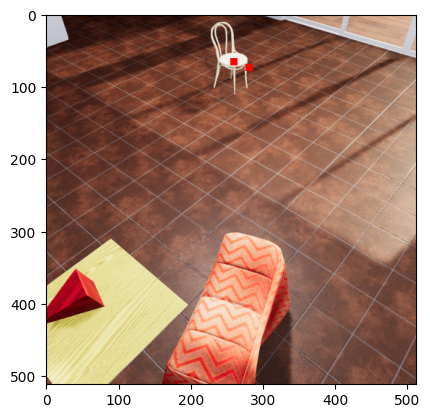

In [212]:
n_positive = 10

height_mask = fg_mask[0].shape[0]
where_trues = []
for mask in fg_mask:
    mask_flat = mask.flatten()
    where_true = np.where(mask_flat)[0]
    where_trues.append(where_true)

def sample_pair_on_mask(where_true):
    
    np.random.shuffle(where_true)
    
    index_visible = where_true[0] #[np.random.randint(len(where_true))]

    index_visible_x = (index_visible//height_mask)
    index_visible_y = (index_visible%height_mask)
    
    return index_visible, index_visible_x, index_visible_y

all_xy = []

for x in range(n_positive):
    n_objs = len(where_trues)
    wt = np.random.choice(n_objs)
    if x < n_objs:
        wt = x
    wt = where_trues[wt]
    ind, x1, y1 = sample_pair_on_mask(wt)
    ind, x2, y2 = sample_pair_on_mask(wt)
    
    all_xy.append([[x1, y1], [x2, y2]])

rgb_xy = rgb.copy()
rgb_xy[x1:x1+10, y1:y1+10] = [255, 0, 0]
rgb_xy[x2:x2+10, y2:y2+10] = [255, 0, 0]
plt.imshow(rgb_xy)

**neg samples**

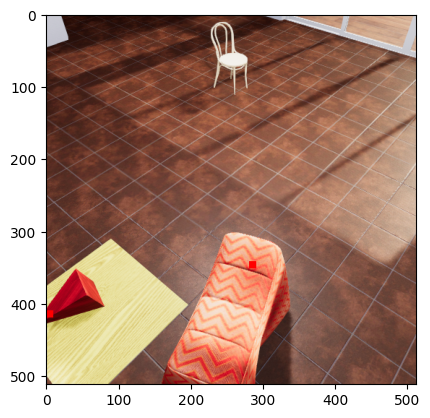

In [215]:
bg_mask_flat = bg_mask.flatten()
where_true_bg = np.where(bg_mask_flat)[0]

where_trues_with_bg = where_trues + [where_true_bg]

all_xy_neg = []

for x in range(n_positive):

    n_objs = len(where_trues)

    valid_inds = list(np.arange(n_objs+1))

    wt = np.random.choice(n_objs)

    if x < n_objs:
        wt = x
    wtrue = where_trues[wt]

    valid_inds.remove(wt)

    ind, x1, y1 = sample_pair_on_mask(wtrue)

    #randomly choose second object incl bkg
    wt = np.random.choice(valid_inds)
    wtrue = where_trues_with_bg[wt]
    ind, x2, y2 = sample_pair_on_mask(wtrue)

    all_xy_neg.append([[x1, y1], [x2, y2]])

rgb_xy = rgb.copy()

kk = all_xy_neg[0]
x1, y1 = kk[0]
x2, y2 = kk[1]

rgb_xy[x1:x1+10, y1:y1+10] = [255, 0, 0]
rgb_xy[x2:x2+10, y2:y2+10] = [255, 0, 0]

plt.imshow(rgb_xy)
